<a href="https://colab.research.google.com/github/jacabenga/hello-world/blob/master/PointNet_tutorial_class_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet
### Tutorial from 

https://github.com/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb

Implementation of PointNet: Deep Learning on Point Sets for 3D Classification: https://arxiv.org/abs/1612.00593



In [2]:
import numpy as np
import math
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import *

In [4]:
import random

print(random.__file__)

/usr/lib/python3.6/random.py


In [5]:
random.seed=42
#function to initialize the pseudo-random number generator in Python. 

In [7]:
!pip install path.py;
from path import Path

In [8]:
#upload (from your local machine) a pre-trained model (save.pth).
# (as training takes some time).
 
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [9]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'sample_data']


In [11]:
# in order to give Colab access to your GDrive files

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [12]:
!ls  # list of all available files 
!pwd

'ANN - regression (Kaggle competition-NY Taxi fare).ipynb'
 colab_tutorial_GPU_1.ipynb
 expert_verified
 __MACOSX
 MNIST_cnn.py
 ModelNet10
 ModelNet10.zip
 pointnet
 PointNetSeg
 PointNet_tutorial_class_1.ipynb
 PointNet_tutorial_Seg_1
 PointNet_Tutorial_Seg_2.ipynb
 points
 save.pth
 Style_Transfer.ipynb
 titanic-passengers.csv
/content/drive/My Drive/Colab Notebooks


## Download the dataset (ModelNet10) directly to the Google Colab Runtime. 
### It is a smaller version of ModelNet40.
## It comprises 10 object categories, 3,991 models for training and 908 for testing.

### We request the dataset in zip format using !wget protocol

In [12]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2020-08-24 10:20:35--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  44.1MB/s    in 11s     

2020-08-24 10:20:47 (40.7 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [22]:
!unzip -q ModelNet10.zip

replace ModelNet10/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [18]:
path = Path('ModelNet10')

### These are the 10 object categories the dataset has.

In [23]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes= {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### This dataset consists of .off files that contain meshes represented by vertices and triangular faces.
### .off  Object File Format: it is a geometry definition file format
### We will need a function to read this type of files:

In [24]:

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [25]:
with open(path/"toilet/train/toilet_0004.off", 'r') as f:
  verts, faces = read_off(f)

In [33]:
i,j,k=np.array(faces).T
x,y,z= np.array(verts).T

In [34]:
len(x)
#len(a)


1288

## This huge function animates and rotates either meshes or pointclouds


In [36]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )
    return fig 

In [37]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i, j=j, k=k)]).show()


# We can customize our own dataset out of the ModelNet10 to feed it into PointNet for training

### Let's visualize vertices
### we can visualize the vertices as matplotlib markers


In [38]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers')]).show()


### It will be more visible to represent vertices as a point cloud

In [40]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [41]:
pcshow(x,y,z)


# TRANSFORMS
### Let's write a function to sample points on the surface uniformly 

### (so it will look more like the real object)

In [43]:


class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [44]:
 pointcloud = PointSampler(500)((verts, faces)) 

In [45]:
pcshow(*pointcloud.T)

## let's normalize it to the unit sphere


In [46]:


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return norm_pointcloud

In [47]:
norm_pointcloud = Normalize()(pointcloud)

In [48]:
pcshow(*norm_pointcloud.T)

# DATA AGUMENTATION
## We can 'produce' more training data by slight variations of the point cloud data
## Let's add random rotation, and random noise


In [50]:
# DATA AGUMENTATION
# Let's add random rotation, and random noise

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),   0],
                               [math.sin(theta), math.cos(theta),     0],
                               [0,                          0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0,0.015, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud
            

                                                           

In [51]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [52]:
pcshow(*noisy_rot_pointcloud.T)

## Transform PCD to Tensor

### we convert the rotated and noisy PCD to tensors (generalized matrices of N-dimensions), for the learning model to understand the data

In [85]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)   

In [86]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.2205,  0.1357, -0.7022],
        [ 0.2019, -0.4603, -0.3940],
        [ 0.0516,  0.4177,  0.4181],
        ...,
        [-0.2023,  0.1322,  0.7396],
        [ 0.3139, -0.2113,  0.1081],
        [ 0.3857, -0.1479,  0.1107]], dtype=torch.float64)

In [87]:
def default_transforms():
    return transforms.Compose([
                               PointSampler(1024),
                               Normalize(),
                               ToTensor()
                               ])

### Let's create our custom PyTorch dataset

#### like in: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

#### "[...]In this tutorial, we have seen how to write and use datasets, transforms and dataloader. torchvision package provides some common datasets and transforms. You might not even have to write custom classes."

In [88]:

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}


## Transforms for training. 1024 points per cloud as in the paper


In [89]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                     ])

In [90]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds= PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [91]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [92]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes:', len(train_ds.classes))
print('Sample pointcloud shape:', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[3420]['category']])


Train dataset size:  3991
Valid dataset size:  908
Number of classes: 10
Sample pointcloud shape: torch.Size([1024, 3])
Class:  table


In [93]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

# Now the MODEL

In [94]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [95]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3,requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()    
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training Loop

You can find a pretrained model here
https://drive.google.com/drive/folders/1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL

In [96]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [97]:
pointnet= PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [98]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [99]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict())
          

In [100]:
train(pointnet, train_loader, valid_loader, save=False)

KeyboardInterrupt: ignored

## Let's TEST it now

In [101]:
from sklearn.metrics import confusion_matrix

In [102]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load("save.pth"))
pointnet.eval();

In [103]:
all_preds = []
all_labels= []
with torch.no_grad():
  for i, data in enumerate(valid_loader):
      print('Batch[%4d / %4d]' % (i+1, len(valid_loader)))

      inputs, labels = data['pointcloud'].float(), data['category']
      outputs, __, __, = pointnet(inputs.transpose(1,2))
      _,preds = torch.max(outputs.data, 1)
      all_preds += list(preds.numpy())
      all_labels += list(labels.numpy())



Batch[   1 /   15]
Batch[   2 /   15]
Batch[   3 /   15]
Batch[   4 /   15]
Batch[   5 /   15]
Batch[   6 /   15]
Batch[   7 /   15]
Batch[   8 /   15]
Batch[   9 /   15]
Batch[  10 /   15]
Batch[  11 /   15]
Batch[  12 /   15]
Batch[  13 /   15]
Batch[  14 /   15]
Batch[  15 /   15]


In [104]:
cm = confusion_matrix(all_labels, all_preds)
cm


array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  96,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   2,  34,   5,   0,  18,   4,  20,   1],
       [  0,   0,   0,   0,  38,   0,  47,   0,   1,   0],
       [  0,   0,   1,   0,  24,  73,   1,   1,   0,   0],
       [  0,   0,   1,   0,   6,   0,  78,   0,   1,   0],
       [  1,   0,   1,   0,   1,   0,   1,  96,   0,   0],
       [  0,   0,   0,   4,   0,   0,   1,   0,  95,   0],
       [  1,   0,  15,   0,   1,   0,   2,   1,   0,  80]])

Let's display the confusion matrix it nicely


In [105]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title= 'confusion matrix', cmap=plt.cm.Blues):
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print('Normalized confusion matrix')
    else:
      print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt= '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range (cm.shape[1])):
      plt.text(j,i, format(cm[i,j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black' )


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


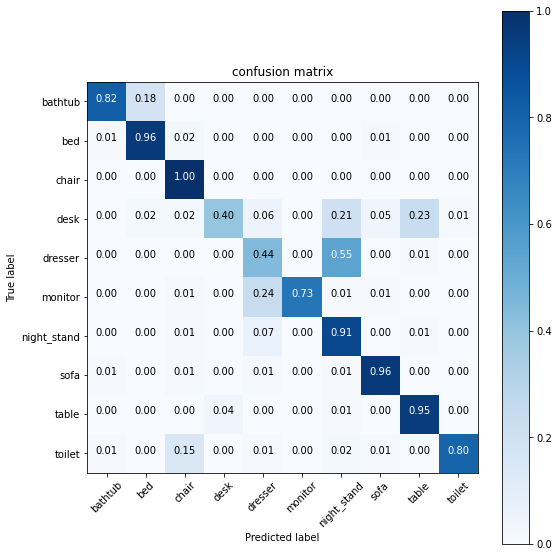

In [106]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True )

Confusion matrix, without normalization


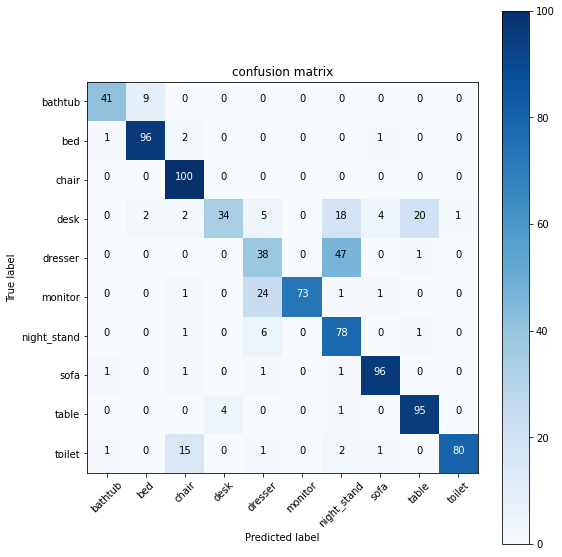

In [107]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,list(classes.keys()), normalize= False)